In [ ]:
import torch
import numpy as np
import scipy as ss
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image
import cv2
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

In [ ]:
# Set up MNIST data loaders
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader  = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=128, shuffle=False)


100%|██████████| 9.91M/9.91M [00:00<00:00, 16.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.48MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.00MB/s]


In [ ]:
# Define the VAE model class
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.fc1 = nn.Linear(28 * 28, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)

        # Decoder layers
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 28 * 28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        mu = self.fc_mu(h1)
        logvar = self.fc_logvar(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h2 = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h2))

    def forward(self, x):
        # Flatten the input image
        x = x.view(-1, 28 * 28)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar



In [ ]:
# Define the loss function (ELBO loss)
def loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss: Binary cross-entropy
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28 * 28), reduction='sum')
    # KL divergence loss: forces the latent distribution to be close to N(0,1)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training function for one epoch
def train(model, optimizer, train_loader, epoch, device):
    model.train() # Set to training mode -- necessary?
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data) # calls model.forward(data).
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
                  f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}")
    print(f"====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}")

# Testing function
def test(model, test_loader, device):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            loss = loss_function(recon, data, mu, logvar)
            test_loss += loss.item()
    test_loss /= len(test_loader.dataset)
    print(f"====> Test set loss: {test_loss:.4f}")
    return test_loss



In [ ]:
# Set device and initialize the model and optimizer
model = VAE(latent_dim=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 10
for epoch in range(1, epochs + 1):
    train(model, optimizer, train_loader, epoch, device)
    test(model, test_loader, device)



Train Epoch: 1 [0/60000 (0%)]	Loss: 546.516357
Train Epoch: 1 [12800/60000 (21%)]	Loss: 190.144516
Train Epoch: 1 [25600/60000 (43%)]	Loss: 171.624039
Train Epoch: 1 [38400/60000 (64%)]	Loss: 174.170761
Train Epoch: 1 [51200/60000 (85%)]	Loss: 156.065414
====> Epoch: 1 Average loss: 182.3548
====> Test set loss: 160.8708
Train Epoch: 2 [0/60000 (0%)]	Loss: 171.500824
Train Epoch: 2 [12800/60000 (21%)]	Loss: 158.065735
Train Epoch: 2 [25600/60000 (43%)]	Loss: 161.147583
Train Epoch: 2 [38400/60000 (64%)]	Loss: 160.925308
Train Epoch: 2 [51200/60000 (85%)]	Loss: 151.866425
====> Epoch: 2 Average loss: 156.6872
====> Test set loss: 152.9868
Train Epoch: 3 [0/60000 (0%)]	Loss: 152.914734
Train Epoch: 3 [12800/60000 (21%)]	Loss: 150.247086
Train Epoch: 3 [25600/60000 (43%)]	Loss: 147.823639
Train Epoch: 3 [38400/60000 (64%)]	Loss: 155.640259
Train Epoch: 3 [51200/60000 (85%)]	Loss: 148.075821
====> Epoch: 3 Average loss: 150.9921
====> Test set loss: 149.0632
Train Epoch: 4 [0/60000 (0%)]	L

In [ ]:
# Visualization: Show original and reconstructed images from the test set
def visualize_reconstructions(model, test_loader, device, num_images=8):
    model.eval() # Set to evaluation mode.
    with torch.no_grad():
        data, _ = next(iter(test_loader))
        data = data.to(device)
        recon, _, _ = model(data)
        # Reshape the outputs to (batch_size, 1, 28, 28)
        recon = recon.view(-1, 1, 28, 28).cpu()
        data = data.cpu()

        fig, axes = plt.subplots(2, num_images, figsize=(num_images * 2, 4))
        for i in range(num_images):
            axes[0, i].imshow(data[i].squeeze(), cmap='gray')
            axes[0, i].axis('off')
            axes[1, i].imshow(recon[i].squeeze(), cmap='gray')
            axes[1, i].axis('off')
        axes[0, 0].set_title('Original')
        axes[1, 0].set_title('Reconstruction')
        plt.show()



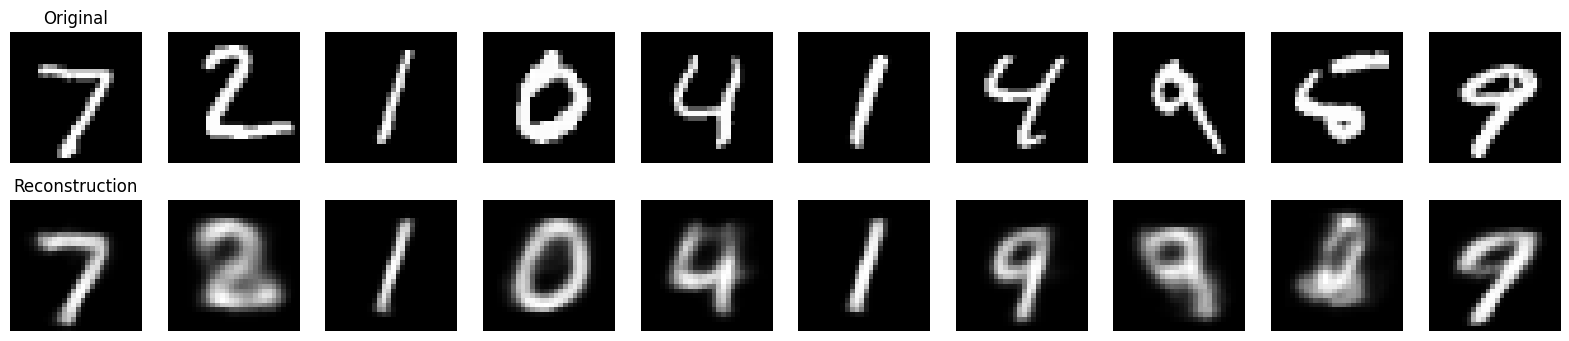

In [ ]:
visualize_reconstructions(model, test_loader, device, num_images = 10)

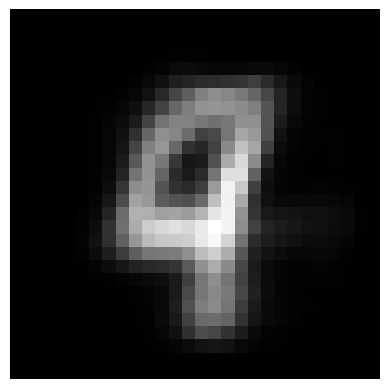

In [ ]:
# Let's generate a new image.
z = torch.randn(1, model.latent_dim).to(device)
x = model.decode(z)

x = x.view(28, 28).cpu().detach().numpy()
plt.imshow(x, cmap='gray')
plt.axis('off')
plt.show()

torch.Size([1024, 1, 28, 28])


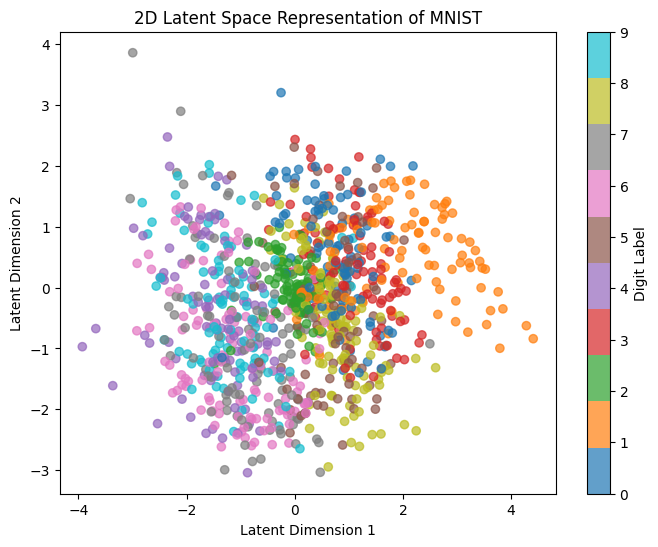

In [ ]:
all_mu = []
all_labels = []

data_loader  = DataLoader(train_dataset, batch_size=1024, shuffle=True)
with torch.no_grad():  # Disable gradient computation
    data, labels = next(iter(data_loader))
    data = data.to(device)
    _, mu, _ = model(data)
    print(data.shape)
    all_mu.append(mu.cpu().numpy())  # Store latent means
    all_labels.append(labels.cpu().numpy())  # Store labels

all_mu = np.concatenate(all_mu, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Plot the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(all_mu[:, 0], all_mu[:, 1], c=all_labels, cmap='tab10', alpha=0.7)
plt.colorbar(label="Digit Label")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space Representation of MNIST")
plt.show()


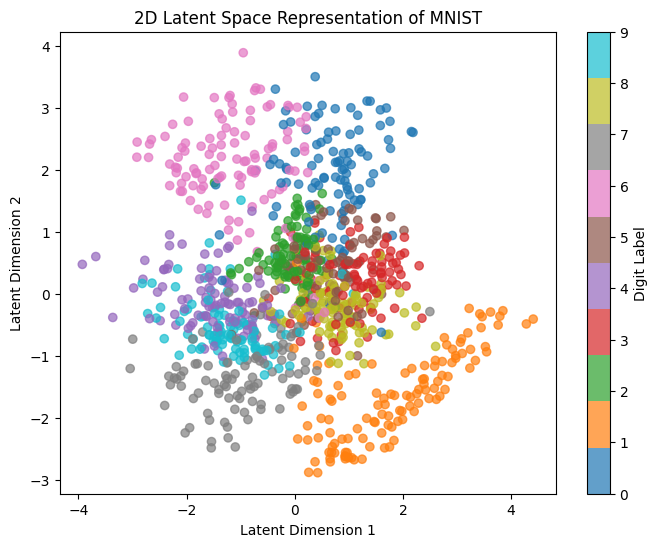

In [ ]:
# Plot the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(all_mu[:, 0], all_mu[:, 2], c=all_labels, cmap='tab10', alpha=0.7)
plt.colorbar(label="Digit Label")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space Representation of MNIST")
plt.show()


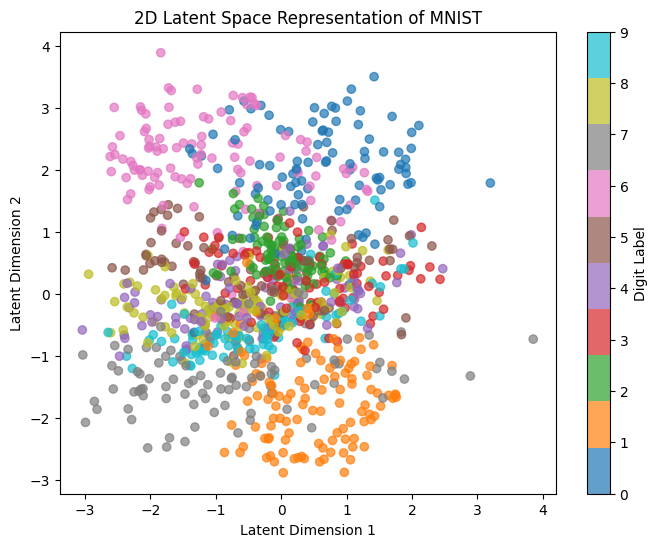

In [ ]:
# Plot the latent space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(all_mu[:, 1], all_mu[:, 2], c=all_labels, cmap='tab10', alpha=0.7)
plt.colorbar(label="Digit Label")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("2D Latent Space Representation of MNIST")
plt.show()


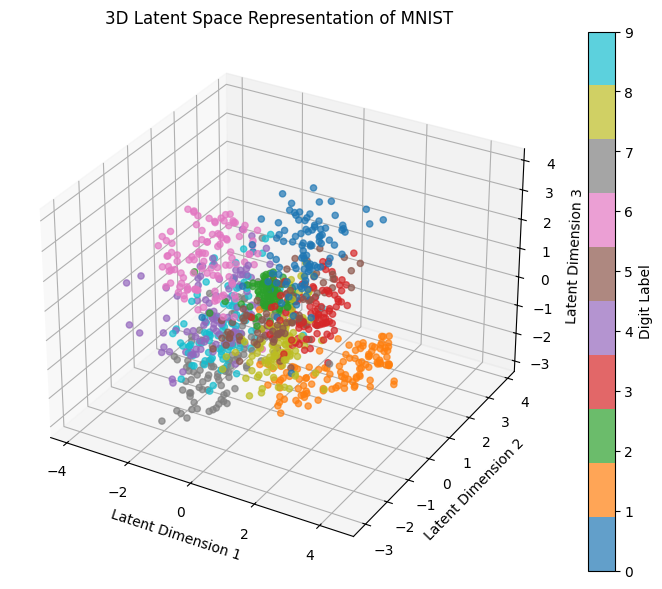

In [ ]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(all_mu[:, 0], all_mu[:, 1], all_mu[:, 2],
                      c=all_labels, cmap='tab10', alpha=0.7)

# Labels
ax.set_xlabel("Latent Dimension 1")
ax.set_ylabel("Latent Dimension 2")
ax.set_zlabel("Latent Dimension 3")
ax.set_title("3D Latent Space Representation of MNIST")

# Add color legend
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("Digit Label")

plt.show()
